In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccf, grangercausalitytests

In [28]:
#In this Notebook we answer these questions for milk 
#How are different grocers responding to each other's price moves, on a certain product/category?
#Is someone always leading price movements, and the others follow?
#Is one retailer always reacting, and never initiates price moves?
#Do prices move exactly in tandem?
#Do prices move completely in random, with no interaction?
#Do prices always rise, and never fall?

In [29]:

column_names = ['nowtime', 'vendor', 'product_id', 'product_name', 'unknown1',
                'current_price', 'unknown2', 'volume', 'unit_price', 'other']


df = pd.read_csv("../data/milk.csv", names=column_names)
df.dropna(subset=['nowtime'], inplace=True)
df['nowtime'] = pd.to_datetime(df['nowtime'], errors='coerce', infer_datetime_format=True)
df.dropna(subset=['nowtime'], inplace=True)

C:\Users\Nah\AppData\Local\Temp\ipykernel_11852\98909275.py:5: DtypeWarning: Columns (2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/milk.csv", names=column_names)
C:\Users\Nah\AppData\Local\Temp\ipykernel_11852\98909275.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['nowtime'] = pd.to_datetime(df['nowtime'], errors='coerce', infer_datetime_format=True)
C:\Users\Nah\AppData\Local\Temp\ipykernel_11852\98909275.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['nowtime'] = pd.to_datetime(df['nowtime'], errors='coerce', infer_datetime_format=True)


In [30]:
# Further cleaning steps
df['current_price'] = pd.to_numeric(df['current_price'], errors='coerce')
df.dropna(subset=['current_price'], inplace=True)
df['vendor'] = df['vendor'].astype('category')
df['year_month'] = df['nowtime'].dt.to_period('M')
df['category'] = 'Milk'

In [31]:
sns.set(style="whitegrid", rc={'figure.figsize': (14, 7)})

df_grouped = df.groupby(['year_month', 'vendor'])['current_price'].mean().reset_index()

df_grouped['year_month'] = df_grouped['year_month'].dt.to_timestamp()

df_pivot = df_grouped.pivot(index='year_month', columns='vendor', values='current_price')

C:\Users\Nah\AppData\Local\Temp\ipykernel_11852\2384422476.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby(['year_month', 'vendor'])['current_price'].mean().reset_index()


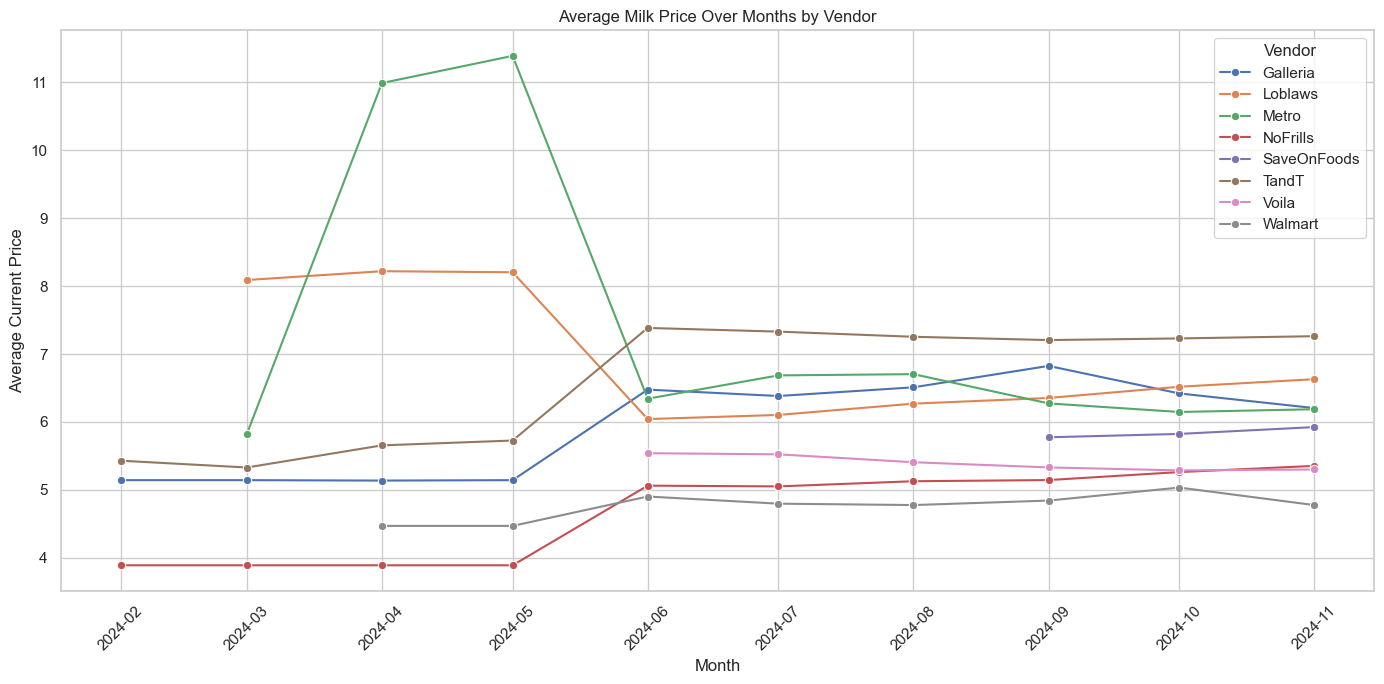

In [32]:
# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_grouped, x='year_month', y='current_price', hue='vendor', marker='o')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.title('Average Milk Price Over Months by Vendor')
plt.xlabel('Month')
plt.ylabel('Average Current Price')
plt.legend(title='Vendor')
plt.tight_layout()
plt.show()


Correlation Matrix:
 vendor       Galleria   Loblaws     Metro  NoFrills  SaveOnFoods     TandT  \
vendor                                                                       
Galleria     1.000000 -0.965589 -0.673690  0.954728    -0.932855  0.963540   
Loblaws     -0.965589  1.000000  0.695334 -0.943203     0.953403 -0.975597   
Metro       -0.673690  0.695334  1.000000 -0.694955    -0.510220 -0.597734   
NoFrills     0.954728 -0.943203 -0.694955  1.000000     0.964186  0.978585   
SaveOnFoods -0.932855  0.953403 -0.510220  0.964186     1.000000  0.994526   
TandT        0.963540 -0.975597 -0.597734  0.978585     0.994526  1.000000   
Voila       -0.019489 -0.949208  0.639649 -0.861379    -0.518930  0.886880   
Walmart      0.880622 -0.870276 -0.920764  0.899362    -0.430577  0.897393   

vendor          Voila   Walmart  
vendor                           
Galleria    -0.019489  0.880622  
Loblaws     -0.949208 -0.870276  
Metro        0.639649 -0.920764  
NoFrills    -0.861379  0.89

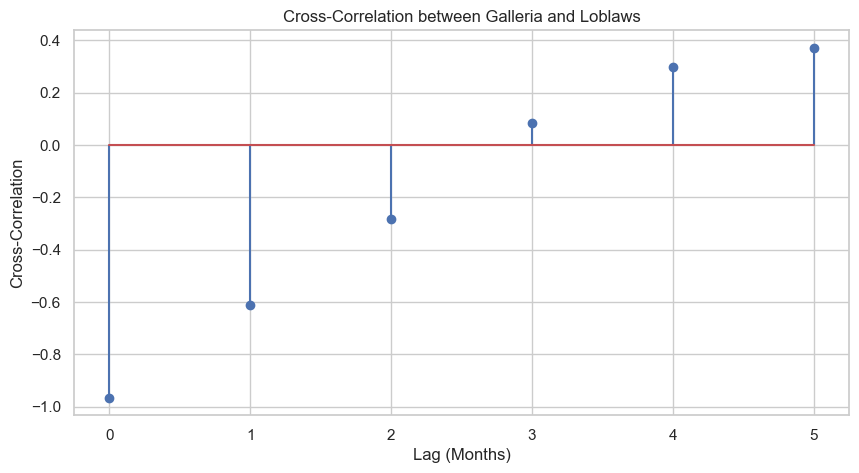

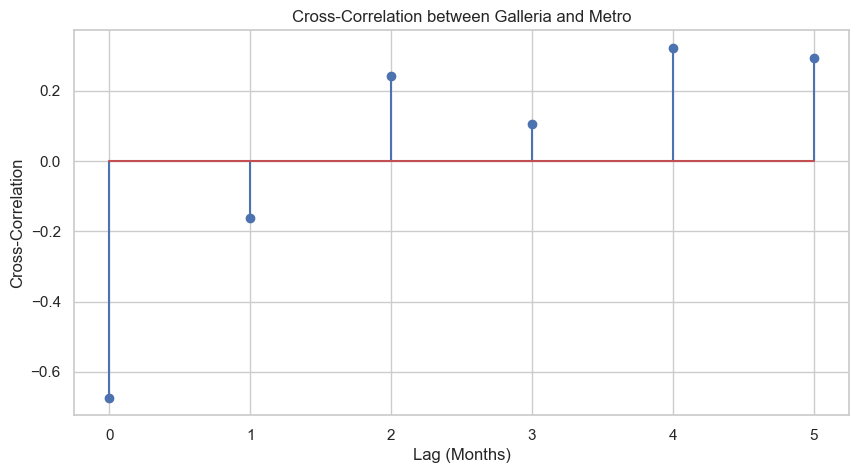

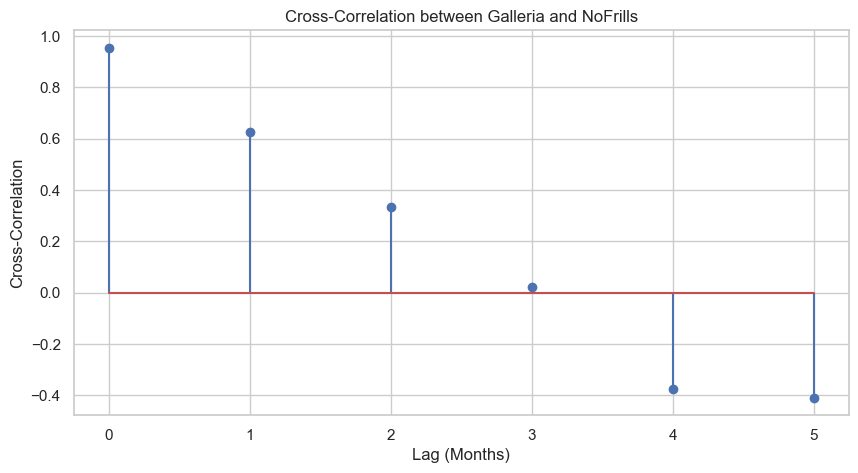

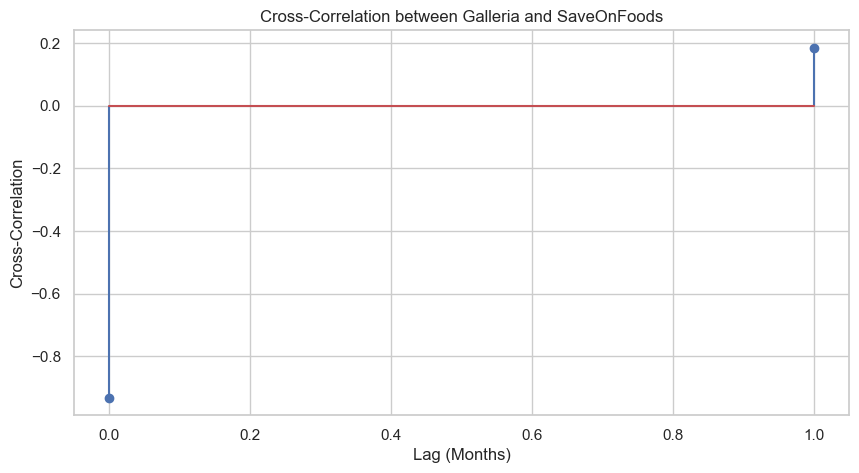

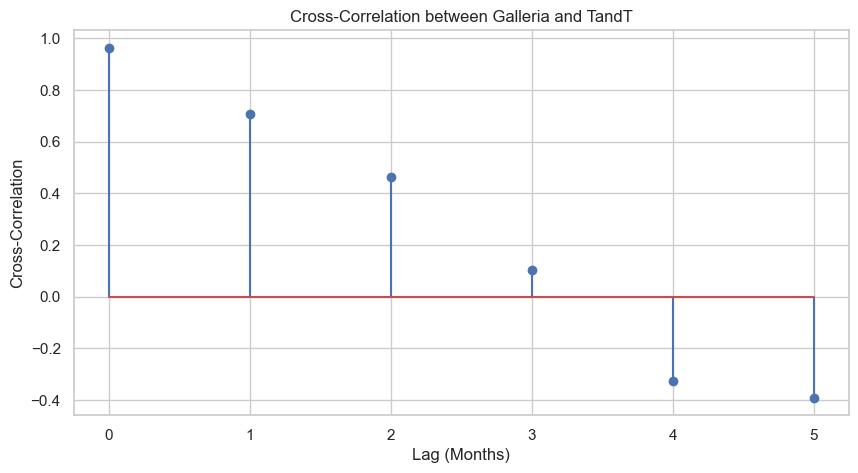

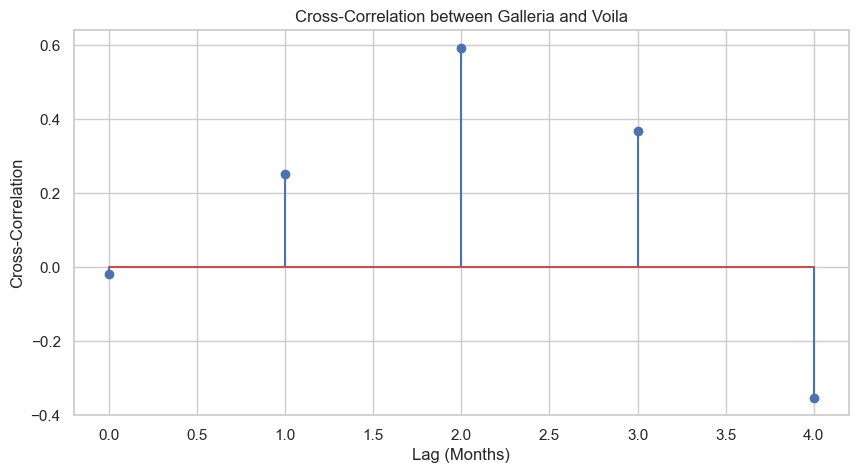

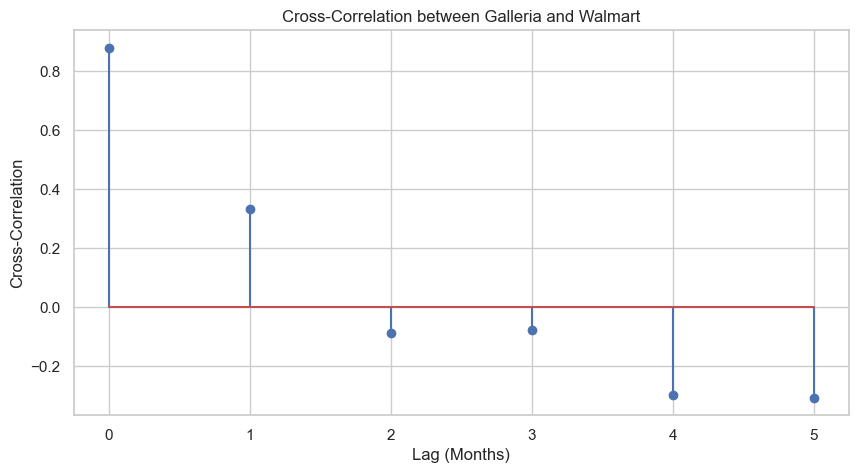

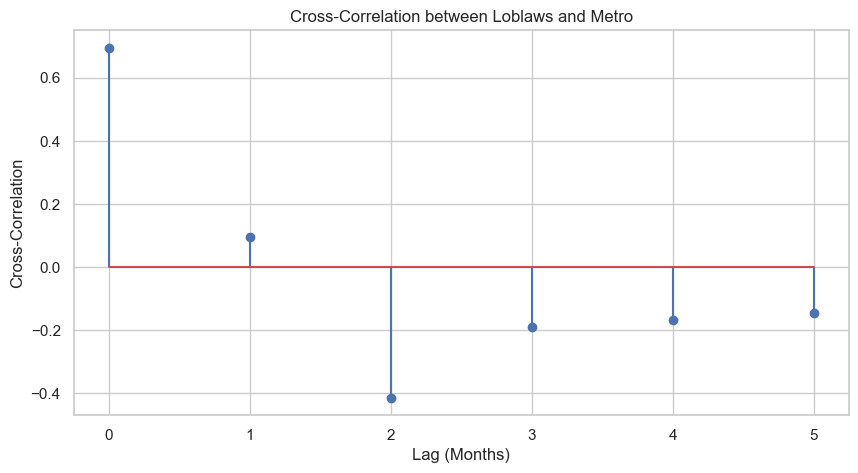

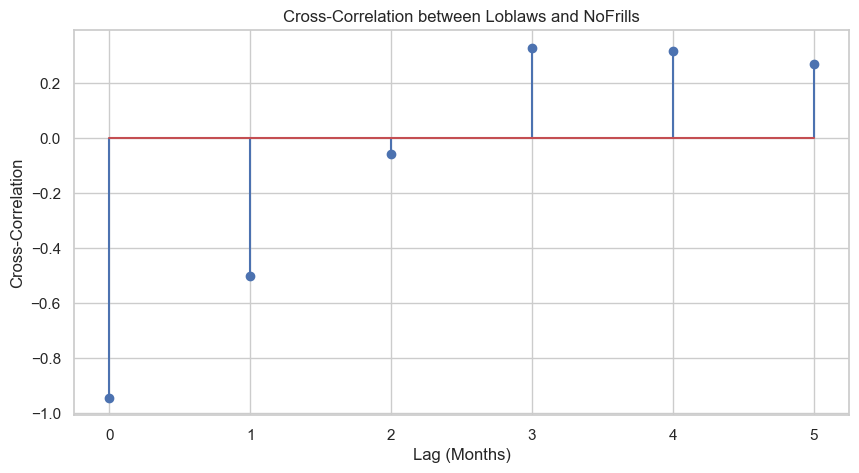

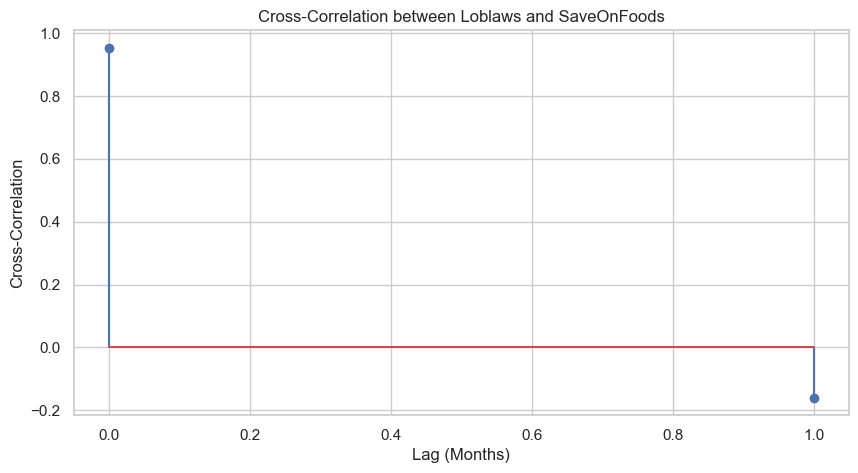

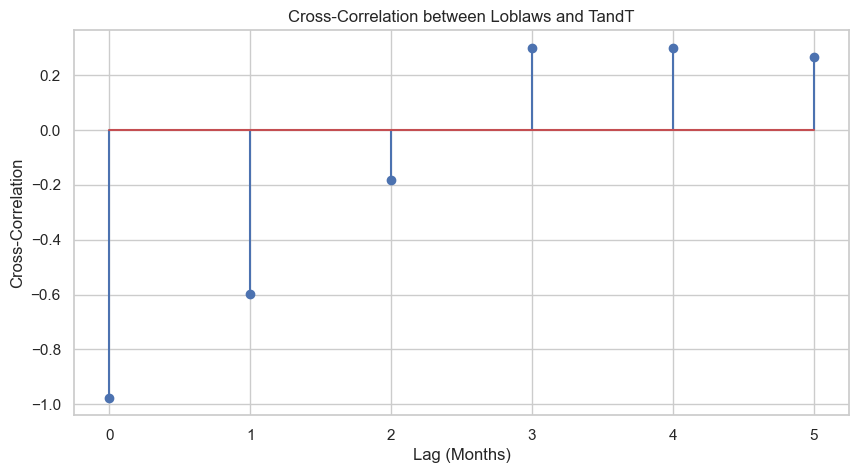

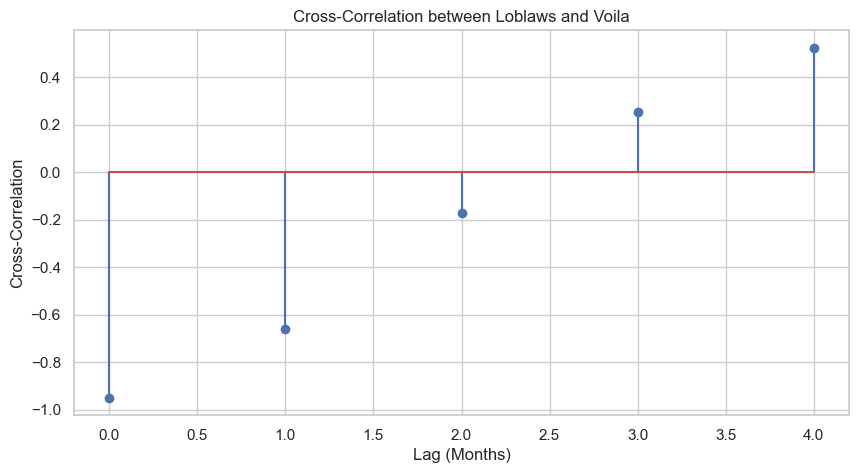

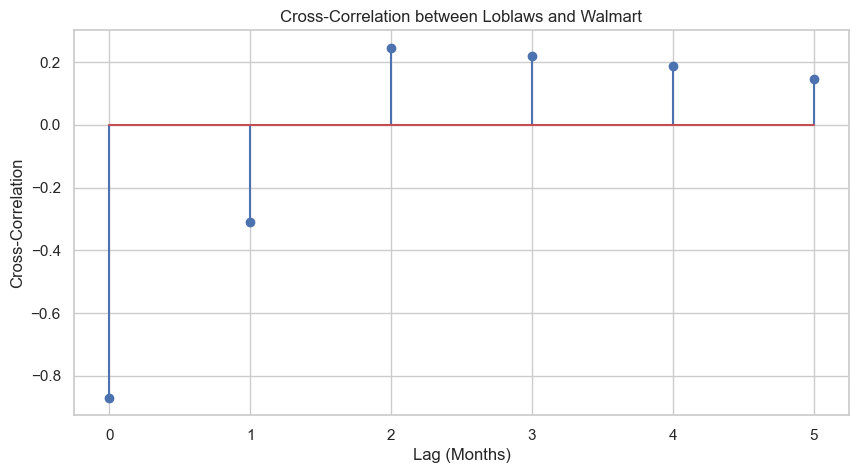

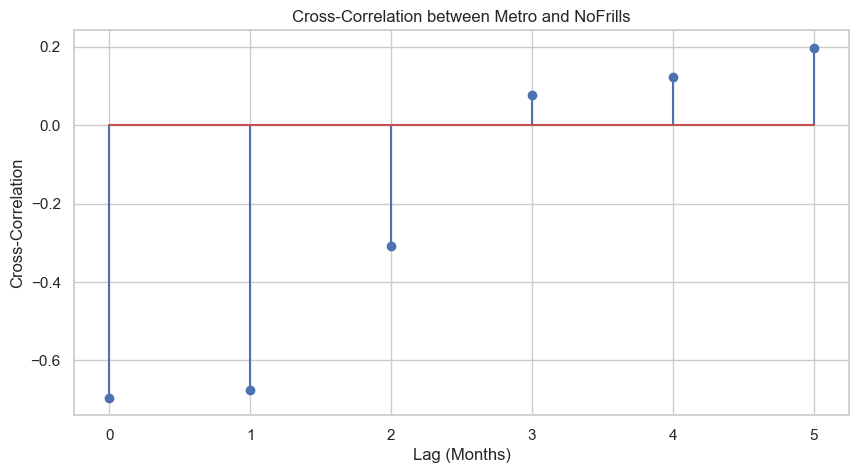

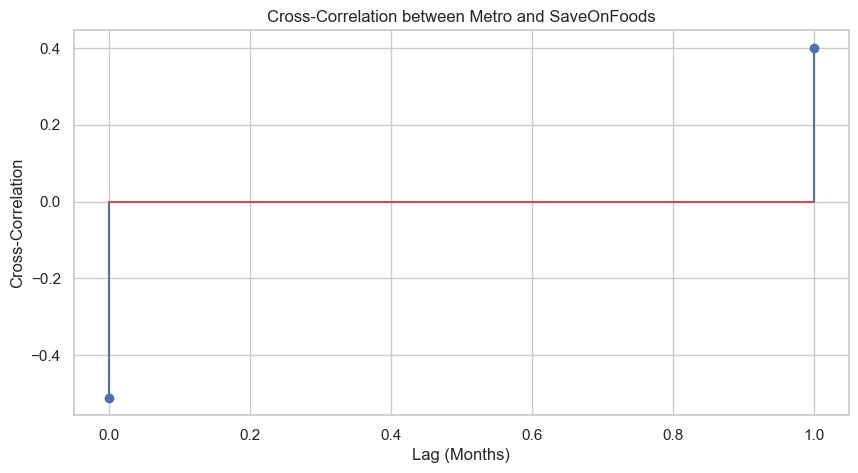

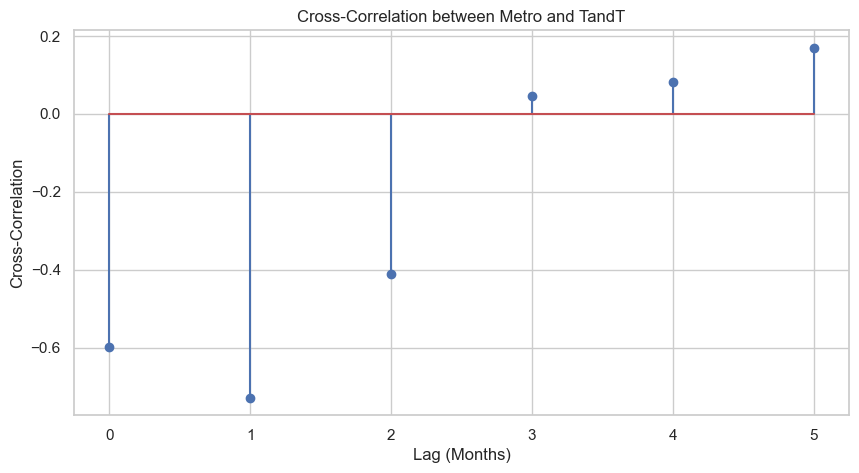

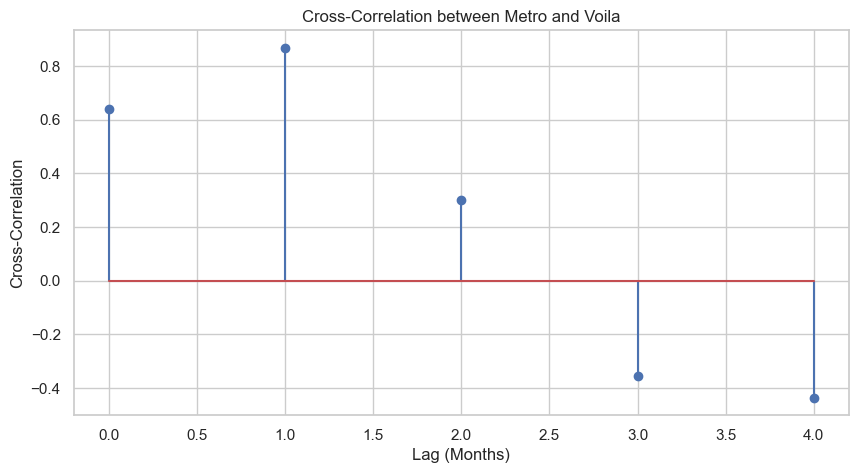

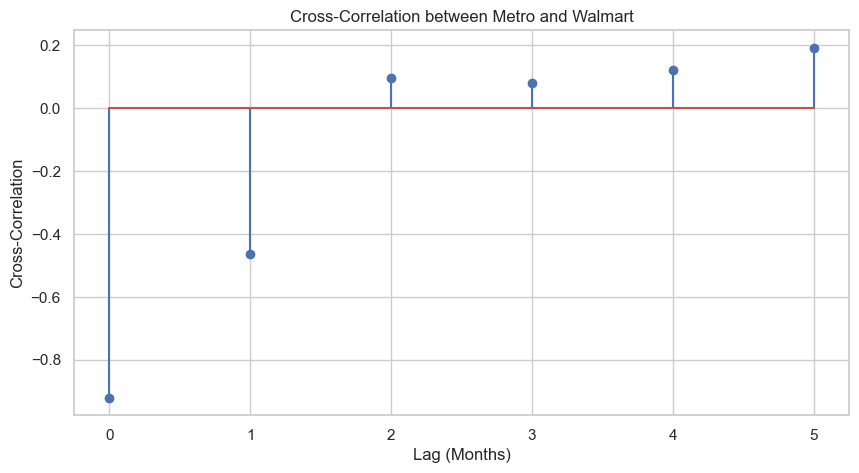

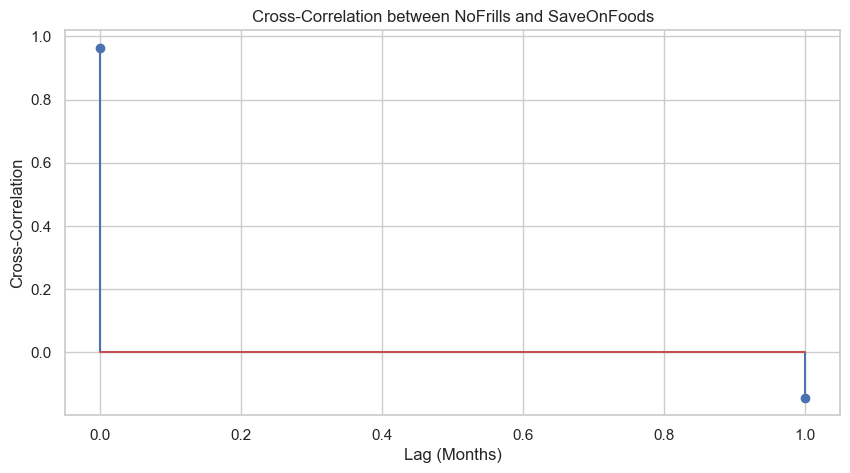

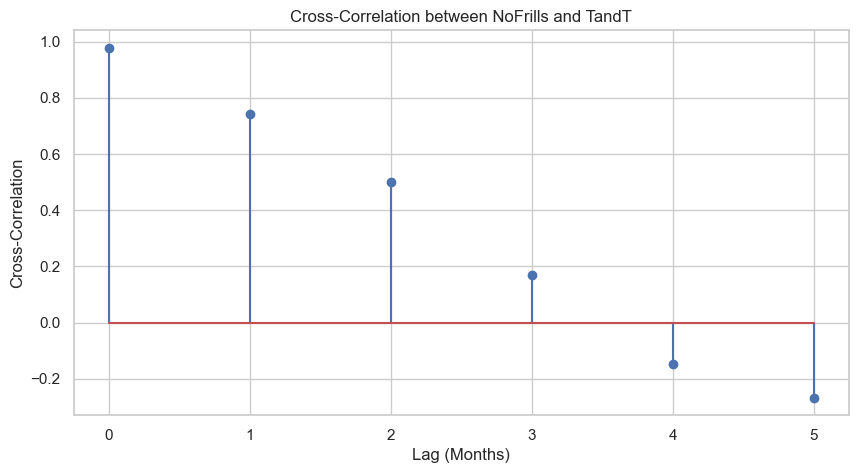

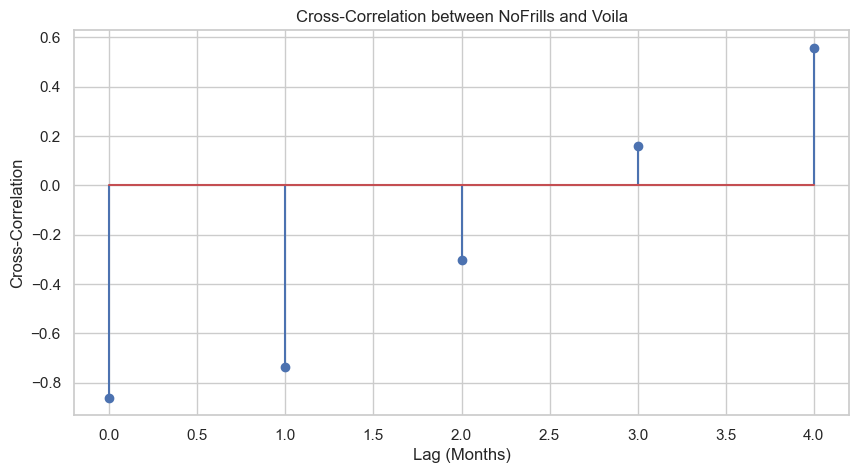

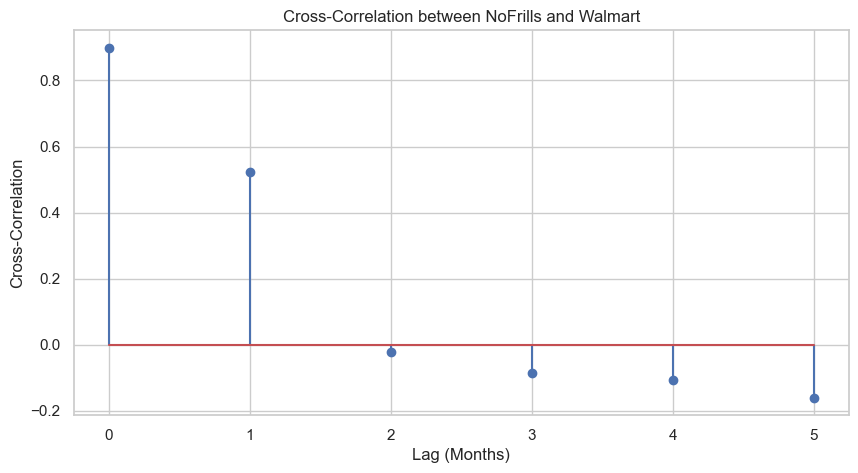

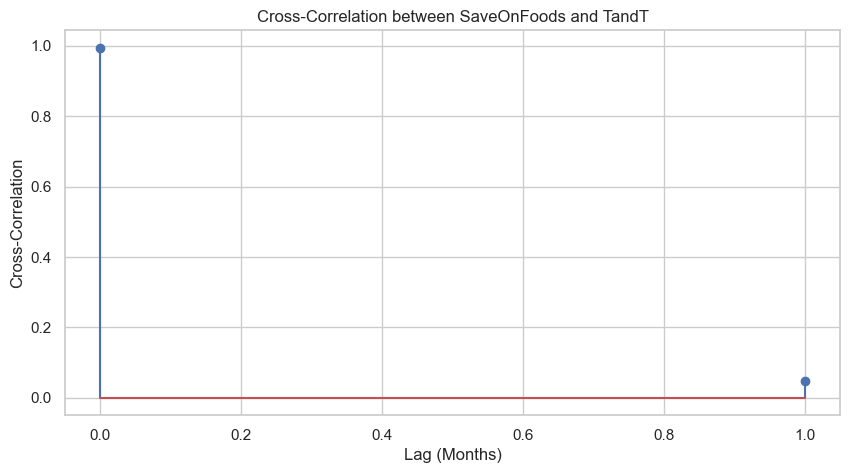

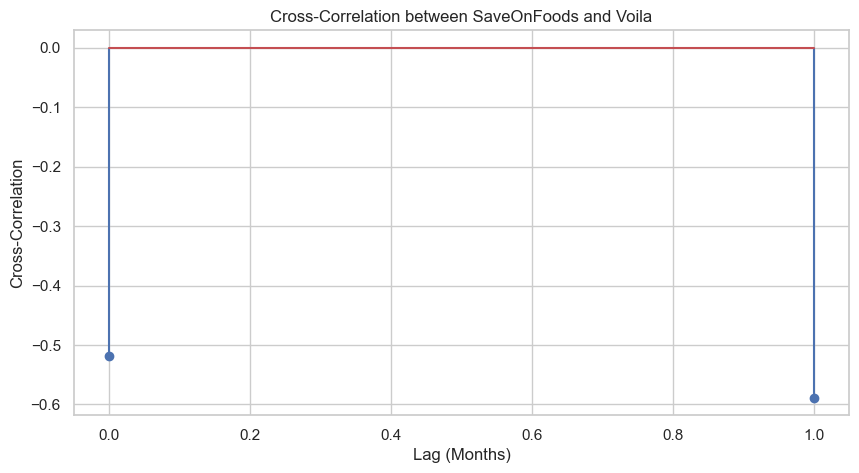

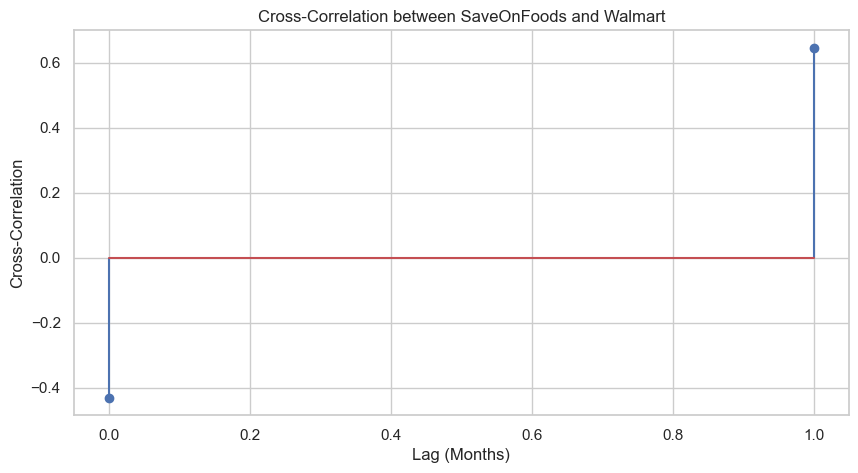

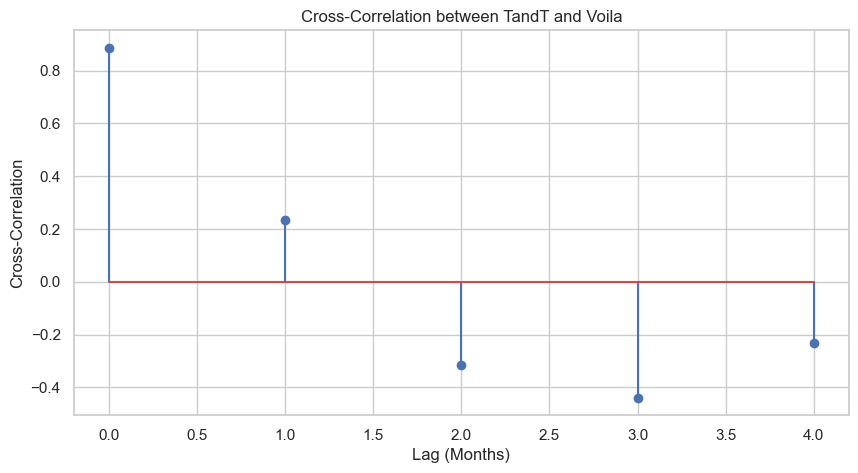

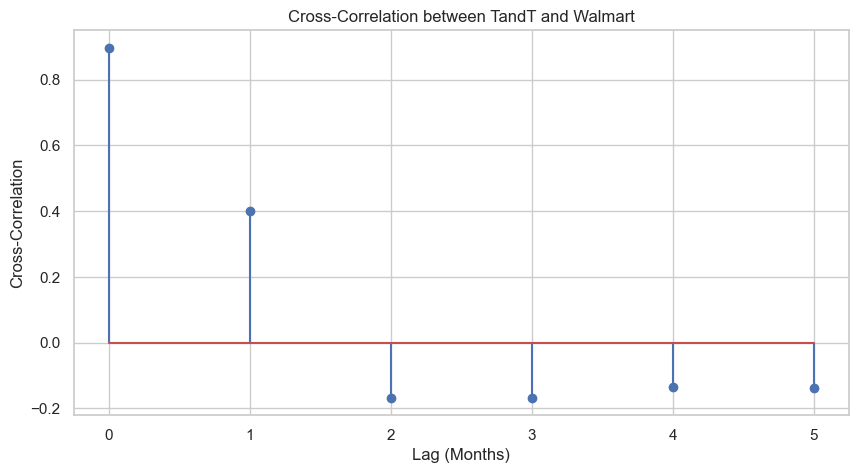

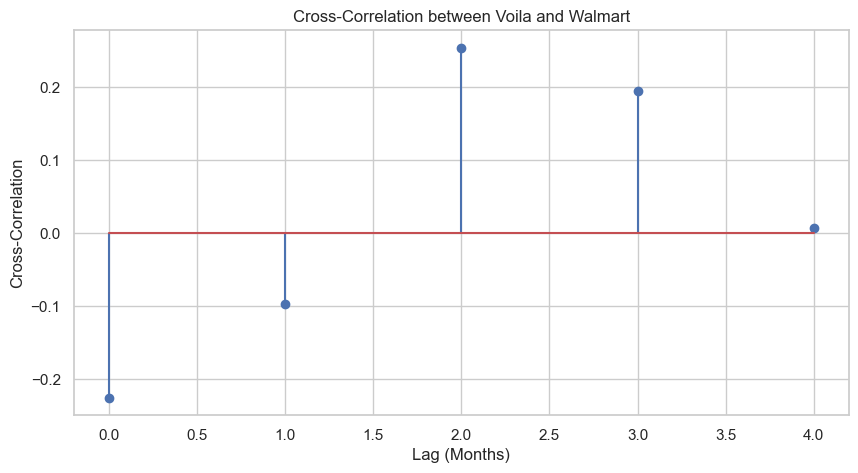

In [33]:
# Correlation Analysis
corr_matrix = df_pivot.corr()
print("\nCorrelation Matrix:\n", corr_matrix)

def compute_ccf(series1, series2, vendor1, vendor2):
    common_length = min(len(series1), len(series2))
    if common_length < 2:
        print(f"Not enough data to compute cross-correlation between {vendor1} and {vendor2}")
        return
    n_lags = min(6, common_length - 1)
    ccf_values = ccf(series1 - series1.mean(), series2 - series2.mean(), adjusted=False)
    ccf_values = ccf_values[:n_lags]
    lags = np.arange(n_lags)
    if len(ccf_values) != n_lags:
        print(f"Mismatch in lengths of lags and ccf_values for {vendor1} and {vendor2}")
        return
    if np.any(np.isnan(ccf_values)):
        print(f"ccf_values contains NaN for {vendor1} and {vendor2}")
        return
    plt.figure(figsize=(10, 5))
    plt.stem(lags, ccf_values)
    plt.title(f'Cross-Correlation between {vendor1} and {vendor2}')
    plt.xlabel('Lag (Months)')
    plt.ylabel('Cross-Correlation')
    plt.show()

vendors = df_pivot.columns.tolist()
for i in range(len(vendors)):
    for j in range(i + 1, len(vendors)):
        series1 = df_pivot[vendors[i]].dropna()
        series2 = df_pivot[vendors[j]].dropna()
        common_dates = series1.index.intersection(series2.index)
        series1_common = series1.loc[common_dates]
        series2_common = series2.loc[common_dates]
        if len(series1_common) >= 2 and len(series2_common) >= 2:
            compute_ccf(series1_common, series2_common, vendors[i], vendors[j])
        else:
            print(f"Not enough data to compute cross-correlation between {vendors[i]} and {vendors[j]}")

In [34]:
def check_stationarity(series):
    result = adfuller(series)
    return result[1] < 0.05

# Granger Causality Test
maxlag = 2 
granger_results = []

for i in range(len(vendors)):
    for j in range(len(vendors)):
        if i != j:
            series1 = df_pivot[vendors[i]].dropna()
            series2 = df_pivot[vendors[j]].dropna()
            common_dates = series1.index.intersection(series2.index)
            series1_common = series1.loc[common_dates]
            series2_common = series2.loc[common_dates]
            data = pd.concat([series1_common, series2_common], axis=1)
            data.columns = [vendors[i], vendors[j]]

            # Remove NaN and infinite values
            data = data.replace([np.inf, -np.inf], np.nan).dropna()
            if data.empty or len(data) <= maxlag + 1:
                print(f"Not enough data to perform Granger causality test between {vendors[i]} and {vendors[j]}")
                continue


            if not check_stationarity(data[vendors[i]]):
                data[vendors[i]] = data[vendors[i]].diff().dropna()
            if not check_stationarity(data[vendors[j]]):
                data[vendors[j]] = data[vendors[j]].diff().dropna()
            data = data.dropna()
            if data.empty or len(data) <= maxlag + 1:
                print(f"Not enough data after differencing for Granger causality test between {vendors[i]} and {vendors[j]}")
                continue


            maxlag_adjusted = min(maxlag, len(data) // 2 - 1)
            if maxlag_adjusted < 1:
                print(f"Not enough data to perform Granger causality test between {vendors[i]} and {vendors[j]}")
                continue

            try:
                print(f'\nGranger Causality Test: {vendors[i]} causes {vendors[j]}')
                test_result = grangercausalitytests(data[[vendors[j], vendors[i]]], maxlag=maxlag_adjusted, verbose=False)
                # Extract p-values for each lag
                for lag in range(1, maxlag_adjusted + 1):
                    p_value = test_result[lag][0]['ssr_ftest'][1]
                    print(f"Lag {lag}: p-value = {p_value:.4f}")
                    granger_results.append({
                        'cause': vendors[i],
                        'effect': vendors[j],
                        'lag': lag,
                        'p_value': p_value
                    })
            except Exception as e:
                print(f"Error performing Granger causality test between {vendors[i]} and {vendors[j]}: {e}")


Granger Causality Test: Galleria causes Loblaws
Lag 1: p-value = 0.7949
Lag 2: p-value = 0.7127

Granger Causality Test: Galleria causes Metro
Lag 1: p-value = 0.9168
Lag 2: p-value = 0.3913

Granger Causality Test: Galleria causes NoFrills
Lag 1: p-value = 0.9848
Lag 2: p-value = 0.9916
Not enough data to perform Granger causality test between Galleria and SaveOnFoods

Granger Causality Test: Galleria causes TandT
Lag 1: p-value = 0.4679
Lag 2: p-value = 0.7215

Granger Causality Test: Galleria causes Voila
Error performing Granger causality test between Galleria and Voila: Insufficient observations. Maximum allowable lag is 0

Granger Causality Test: Galleria causes Walmart
Error performing Granger causality test between Galleria and Walmart: Insufficient observations. Maximum allowable lag is 1

Granger Causality Test: Loblaws causes Galleria
Lag 1: p-value = 0.2437
Lag 2: p-value = 0.5113

Granger Causality Test: Loblaws causes Metro
Lag 1: p-value = 0.0497
Lag 2: p-value = 0.0028

c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\sta

Lag 1: p-value = 0.9543
Lag 2: p-value = 0.7879

Granger Causality Test: NoFrills causes Metro
Lag 1: p-value = 0.0327
Lag 2: p-value = 0.0017
Not enough data to perform Granger causality test between NoFrills and SaveOnFoods

Granger Causality Test: NoFrills causes TandT
Lag 1: p-value = 0.3297
Lag 2: p-value = 0.5009

Granger Causality Test: NoFrills causes Voila
Lag 1: p-value = 0.6576

Granger Causality Test: NoFrills causes Walmart
Error performing Granger causality test between NoFrills and Walmart: Insufficient observations. Maximum allowable lag is 1
Not enough data to perform Granger causality test between SaveOnFoods and Galleria
Not enough data to perform Granger causality test between SaveOnFoods and Loblaws
Not enough data to perform Granger causality test between SaveOnFoods and Metro
Not enough data to perform Granger causality test between SaveOnFoods and NoFrills
Not enough data to perform Granger causality test between SaveOnFoods and TandT
Not enough data to perform 

c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\sta


Granger Causality Test: Walmart causes TandT
Error performing Granger causality test between Walmart and TandT: Insufficient observations. Maximum allowable lag is 1

Granger Causality Test: Walmart causes Voila
Lag 1: p-value = 0.0847


c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [35]:
granger_df = pd.DataFrame(granger_results)
significant_results = granger_df[granger_df['p_value'] < 0.05]


print("\nSignificant Granger Causality Relationships (p-value < 0.05):")
if not significant_results.empty:
    print(significant_results[['cause', 'effect', 'lag', 'p_value']])
else:
    print("No significant Granger causality relationships found.")
    
# Calculate Net Price Change
for vendor in df_pivot.columns:
    series = df_pivot[vendor].dropna()
    if len(series) >= 2:
        price_start = series.iloc[0]
        price_end = series.iloc[-1]
        net_change = price_end - price_start
        percentage_change = (net_change / price_start) * 100
        print(f"Vendor: {vendor}, Net Price Change: {net_change:.2f}, Percentage Change: {percentage_change:.2f}%")
    else:
        print(f"Not enough data to calculate net price change for vendor {vendor}")


Significant Granger Causality Relationships (p-value < 0.05):
       cause    effect  lag   p_value
10   Loblaws     Metro    1  0.049731
11   Loblaws     Metro    2  0.002821
15   Loblaws     TandT    2  0.015716
20     Metro   Loblaws    2  0.012223
22     Metro  NoFrills    2  0.032936
24     Metro     TandT    2  0.021719
30  NoFrills     Metro    1  0.032741
31  NoFrills     Metro    2  0.001715
38     TandT   Loblaws    2  0.043360
39     TandT     Metro    1  0.034905
40     TandT     Metro    2  0.010632
Vendor: Galleria, Net Price Change: 1.06, Percentage Change: 20.63%
Vendor: Loblaws, Net Price Change: -1.46, Percentage Change: -18.05%
Vendor: Metro, Net Price Change: 0.36, Percentage Change: 6.25%
Vendor: NoFrills, Net Price Change: 1.46, Percentage Change: 37.62%
Vendor: SaveOnFoods, Net Price Change: 0.15, Percentage Change: 2.60%
Vendor: TandT, Net Price Change: 1.83, Percentage Change: 33.75%
Vendor: Voila, Net Price Change: -0.24, Percentage Change: -4.33%
Vendor: Wal